In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib


In [ ]:
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

df.drop("customerID", axis=1, inplace=True)

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

df.dropna(inplace=True)

df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [ ]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns


In [ ]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])


In [ ]:
logreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

logreg_param_grid = {
    "model__C": [0.01, 0.1, 1, 10]
}

logreg_grid = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=5, scoring="accuracy", n_jobs=-1)
logreg_grid.fit(X_train, y_train)

print(logreg_grid.best_params_)
y_pred_lr = logreg_grid.predict(X_test)
print(classification_report(y_test, y_pred_lr))

joblib.dump(logreg_grid.best_estimator_, "logistic_regression_churn_pipeline.joblib")


{'model__C': 0.01}
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1033
           1       0.65      0.51      0.57       374

    accuracy                           0.80      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407



['logistic_regression_churn_pipeline.joblib']

In [ ]:
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier())
])

rf_param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20]
}

rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring="accuracy", n_jobs=-1)
rf_grid.fit(X_train, y_train)

print(rf_grid.best_params_)
y_pred_rf = rf_grid.predict(X_test)
print(classification_report(y_test, y_pred_rf))

joblib.dump(rf_grid.best_estimator_, "random_forest_churn_pipeline.joblib")


{'model__max_depth': 10, 'model__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



['random_forest_churn_pipeline.joblib']

In [ ]:
model = joblib.load("random_forest_churn_pipeline.joblib")
sample = X_test.iloc[[0]]
prediction = model.predict(sample)
print("Prediction (1=Churn):", prediction)


Prediction (1=Churn): [0]


Prediction (1=Churn): [0]
Prediction Probability: [[0.99710441 0.00289559]]

Sample Features:


,974
gender,Female
SeniorCitizen,0
Partner,Yes
Dependents,Yes
tenure,59
PhoneService,Yes
MultipleLines,No
InternetService,DSL
OnlineSecurity,No
OnlineBackup,Yes


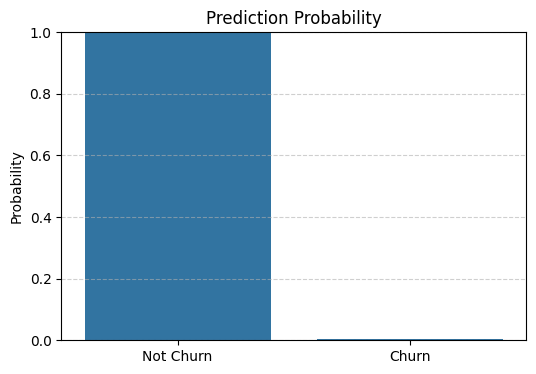

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

model = joblib.load("random_forest_churn_pipeline.joblib")
sample = X_test.iloc[[0]]
prediction = model.predict(sample)
proba = model.predict_proba(sample)

print("Prediction (1=Churn):", prediction)
print("Prediction Probability:", proba)

print("\nSample Features:")
display(sample.T)

plt.figure(figsize=(6,4))
sns.barplot(x=["Not Churn", "Churn"], y=proba[0])
plt.title("Prediction Probability")
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


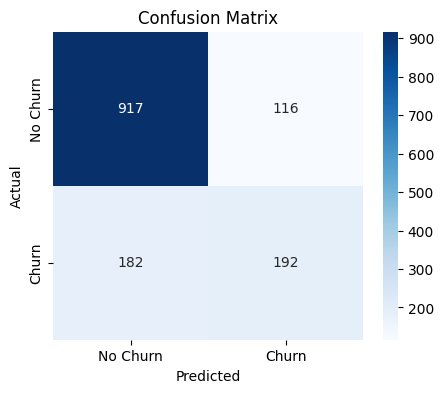

In [ ]:
y_pred_all = model.predict(X_test)

results_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred_all
})

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred_all)
plt.figure(figsize=(5,4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


/tmp/ipython-input-18-4202638422.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred_all, palette="pastel")


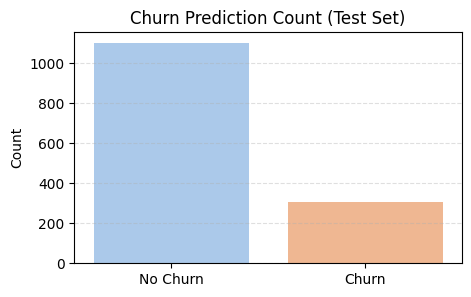

In [ ]:
plt.figure(figsize=(5,3))
sns.countplot(x=y_pred_all, palette="pastel")
plt.title("Churn Prediction Count (Test Set)")
plt.xticks([0, 1], ["No Churn", "Churn"])
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


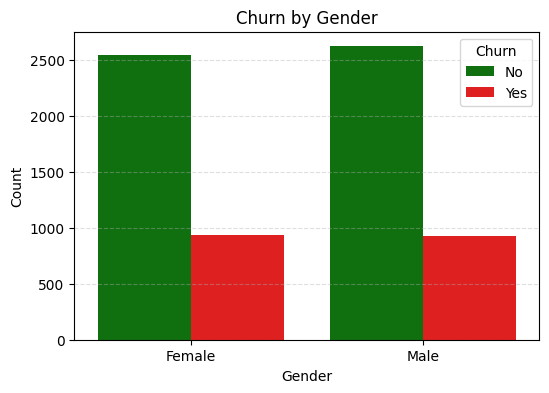

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="gender", hue="Churn", palette=["green", "red"])
plt.title("Churn by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Churn", labels=["No", "Yes"])
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


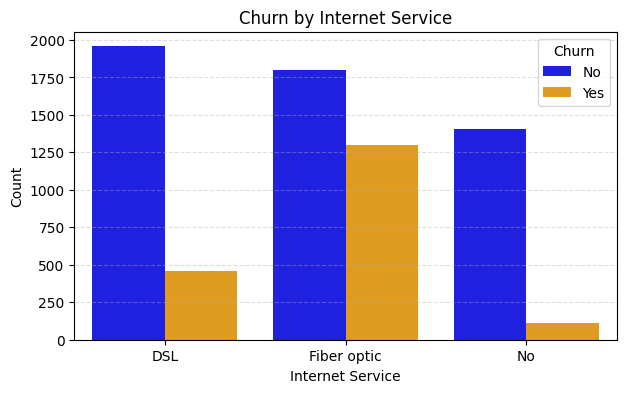

In [ ]:
plt.figure(figsize=(7, 4))
sns.countplot(data=df, x="InternetService", hue="Churn", palette=["blue", "orange"])
plt.title("Churn by Internet Service")
plt.xlabel("Internet Service")
plt.ylabel("Count")
plt.legend(title="Churn", labels=["No", "Yes"])
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


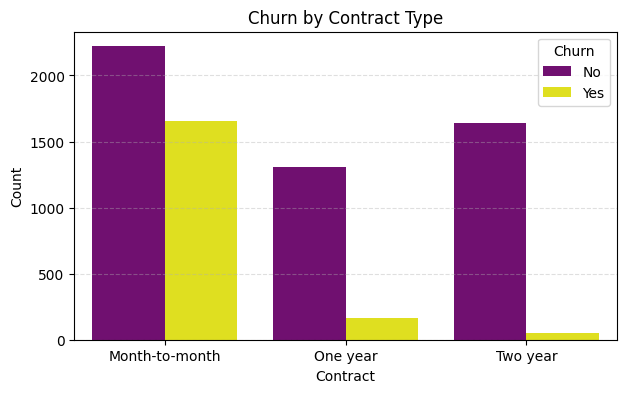

In [ ]:
plt.figure(figsize=(7, 4))
sns.countplot(data=df, x="Contract", hue="Churn", palette=["purple", "yellow"])
plt.title("Churn by Contract Type")
plt.xlabel("Contract")
plt.ylabel("Count")
plt.legend(title="Churn", labels=["No", "Yes"])
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


In [ ]:
pip install gradio


In [ ]:
import gradio as gr
import joblib
import pandas as pd

model = joblib.load("random_forest_churn_pipeline.joblib")

def predict_churn(gender, senior_citizen, partner, dependents, tenure, phone_service,
                  multiple_lines, internet_service, online_security, online_backup,
                  device_protection, tech_support, streaming_tv, streaming_movies,
                  contract, paperless_billing, payment_method, monthly_charges, total_charges):

    input_dict = {
        "gender": gender,
        "SeniorCitizen": int(senior_citizen),
        "Partner": partner,
        "Dependents": dependents,
        "tenure": float(tenure),
        "PhoneService": phone_service,
        "MultipleLines": multiple_lines,
        "InternetService": internet_service,
        "OnlineSecurity": online_security,
        "OnlineBackup": online_backup,
        "DeviceProtection": device_protection,
        "TechSupport": tech_support,
        "StreamingTV": streaming_tv,
        "StreamingMovies": streaming_movies,
        "Contract": contract,
        "PaperlessBilling": paperless_billing,
        "PaymentMethod": payment_method,
        "MonthlyCharges": float(monthly_charges),
        "TotalCharges": float(total_charges)
    }

    input_df = pd.DataFrame([input_dict])
    prediction = model.predict(input_df)[0]
    prob = model.predict_proba(input_df)[0][1]

    return f"Churn: {'Yes' if prediction == 1 else 'No'} (Probability: {prob:.2f})"

interface = gr.Interface(
    fn=predict_churn,
    inputs=[
        gr.Radio(["Male", "Female"], label="Gender"),
        gr.Checkbox(label="Senior Citizen"),
        gr.Radio(["Yes", "No"], label="Partner"),
        gr.Radio(["Yes", "No"], label="Dependents"),
        gr.Slider(0, 72, step=1, label="Tenure (months)"),
        gr.Radio(["Yes", "No"], label="Phone Service"),
        gr.Radio(["No", "Yes", "No phone service"], label="Multiple Lines"),
        gr.Radio(["DSL", "Fiber optic", "No"], label="Internet Service"),
        gr.Radio(["Yes", "No", "No internet service"], label="Online Security"),
        gr.Radio(["Yes", "No", "No internet service"], label="Online Backup"),
        gr.Radio(["Yes", "No", "No internet service"], label="Device Protection"),
        gr.Radio(["Yes", "No", "No internet service"], label="Tech Support"),
        gr.Radio(["Yes", "No", "No internet service"], label="Streaming TV"),
        gr.Radio(["Yes", "No", "No internet service"], label="Streaming Movies"),
        gr.Radio(["Month-to-month", "One year", "Two year"], label="Contract"),
        gr.Radio(["Yes", "No"], label="Paperless Billing"),
        gr.Radio([
            "Electronic check", "Mailed check", "Bank transfer (automatic)", "Credit card (automatic)"
        ], label="Payment Method"),
        gr.Number(label="Monthly Charges"),
        gr.Number(label="Total Charges"),
    ],
    outputs="text",
    title="Customer Churn Prediction"
)

interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3b7677fa64cd7e4cc5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
